<a href="https://colab.research.google.com/github/alexfok/IntroDeepLearning2022/blob/main/IDL_Project_sup_l.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Alexander Fok 308669944

Avi Dvir 204423735

Gal Cohen 204675805

# Project: Unsupervised Deep Embedding for Clustering Analysis - Part#1 - Data Exploration and Models Training

**Project Supervisor**: May Malka.

In this project, we build a Unsupervised Deep Embedding for Clustering Analysis with AE, etc 


# **Section 1: Environment Initialization**

## Imports


In [50]:
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as nnF
from torchvision.utils import make_grid
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision.transforms.functional as F
from torchvision.utils import make_grid
import os
import zipfile


# Install dependencies
%pip install wget torch torchvision imageio
import wget

# Imports for MNIST loading
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import datasets, transforms

# Imports for STL10 loading
import sys
import os, sys, tarfile, errno
import random


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Control Variables and Initialization

In [51]:
# Notebook Control variables
DEBUG_STL10 = False
# Print DEBUG info
DEBUG = False
# Variable controlling debug prints while training\infering with NN
DEBUG_NN = False
# Create the data sets or load the preloaded np arrays
CREATE_DATA = True
# Path to save the created numpy arrays
array_save_path = '/content/gdrive/My Drive/IntroDeepLearning2022Data/project/data.npy'
# Path to load the created numpy arrays
array_load_path = '/content/gdrive/My Drive/IntroDeepLearning2022Data/project/data.npy.npz'
#best_model_path = '/content/gdrive/MyDrive/IntroDeepLearning2022Data/project/model_chkpt_epoch_20.pk'
#checkpoint_path = '/content/gdrive/MyDrive/IntroDeepLearning2022Data/project/model_chkpt_epoch_{}.pk'
#model_path = '/content/gdrive/My Drive/IntroDeepLearning2022Data/project_model2.pk'
model_path_stl10 = '/content/gdrive/My Drive/IntroDeepLearning2022Data/project/project_model2_stl10.pk'
model_path_mnist = '/content/gdrive/My Drive/IntroDeepLearning2022Data/project/project_model2_mnist.pk'
# Raw data set paths
path_train = "/content/gdrive/My Drive/IntroDeepLearning2022Data/project"
#path_train = "/content/gdrive/My Drive/IntroDeepLearning2022Data/data/train/*.*"
#path_test_m = "/content/gdrive/My Drive/IntroDeepLearning2022Data/data/test_m/*.*"
#path_test_w = "/content/gdrive/My Drive/IntroDeepLearning2022Data/data/test_w/*.*"
# Set random seeds

# use GPU for computation if possible: Go to RUNTIME -> CHANGE RUNTIME TYPE -> GPU
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('CPU\GPI device: {dev}')

torch.manual_seed(1)
torch.cuda.manual_seed(1)

CPU\GPI device: {dev}


Connect to your Google Drive, select the path in your drive for saving the checkpoints of your model, which we will train later.

## Helper Functions


In [52]:
# Function to count number of model parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

def plot_image(image):
    """
    :param image: the image to be plotted in a 3-D matrix format
    :return: None
    """
    plt.imshow(image)
    plt.show()

# Function to display images
def display_images(in_, out, n=1, label=None, count=False):
    for N in range(n):
        if in_ is not None:
            in_pic = in_.data.cpu().view(-1, 28, 28)
            plt.figure(figsize=(15, 4))
            plt.suptitle(label + ' – real test data / reconstructions', color='w', fontsize=16)
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N], cmap='Greys_r')
                plt.axis('off')
        out_pic = out.data.cpu().view(-1, 28, 28)
        plt.figure(figsize=(15, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N], cmap='Greys_r')
            plt.axis('off')
            if count: plt.title(str(4 * N + i), color='w')

# Section 2: Data Load
## Data Statistics

In this assignement we are using the CelebFaces Attributes Dataset (CelebA).

The CelebA dataset, as its name suggests, is comprised of celebrity faces. The images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong.

**Overall**

- 202,599 number of face images of various celebrities
- 10,177 unique identities, but names of identities are not given
- 40 binary attribute annotations per image
- 5 landmark locations

In this torchvision version of the dataset, each image is in the shape of
$[218,178,3]$ and the values are in $[0,1]$.

MNIST Data
- number of images in training set: 60000
- number of images in test set: 10000
- image shape: $(28, 28)$.
- 10 image classes: ``0,1,2,3,4,5,6,7,8,9``
- We resize the images to $(32, 32)$, to allow the usage of the same NN architecture, that assumes image shapes of $(H/2^4, W/2^4)$.

STL10 Data
- stl10_binary.tar.gz size: 2.5 gb
- number of images in training set: 5000
- number of images in test set: 8000
- image shape: $(96, 96, 3)$.
- 10 image classes: 
 `` airplane, bird, car, cat, deer, dog, horse, monkey, ship, truck``
- Due to lack of RAM, we didn't use unlabeled images dataset - 100000 images.

## Load MNIST dataset
We direclty load the images by batches. Note that we keep the division of the data into training and test sets to get some sense on how the variational autoencoder adapts during the trainig procedure. Nonetheless, there are no lables used here as this is unsupervised learning.

In [53]:
#mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
#mnist_data = list(mnist_data)[:4096]

#batch_size = 256
 
#train_loader = torch.utils.data.DataLoader(
#    MNIST('./data', train=True, download=True,
#                   transform=transforms.ToTensor()),
#    batch_size=batch_size, shuffle=True)
#test_loader = torch.utils.data.DataLoader(
#    MNIST('./data', train=False, transform=transforms.ToTensor()),
#    batch_size=batch_size, shuffle=True)

#mnist_data = train_loader.dataset.detach().numpy()
#mnist_data = train_loader.dataset
#mnist_data = next(iter(train_loader))[0].numpy()
def create_mnist_dataset():
    print(f'Creating MNIST dataset')
    norm_mean = 0.5 
    norm_std = 0.5 
#    image_h, image_w = (28, 28)
    image_size = (32, 32)

#    trfm = transforms.Compose([transforms.ToTensor(), transforms.Normalize((norm_mean,), (norm_std,))])
#    trfm = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor(), transforms.Grayscale(3)])
    trfm = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor()])
#    trfm = transforms.ToTensor()

    mnist_data = datasets.MNIST('data', train=True, download=True, transform=trfm)
    mnist_data_test = datasets.MNIST('data', train=False, download=True, transform=trfm)
    mnist_data_nparray = mnist_data.data.numpy()
    print(f'type(mnist_data_nparray): {type(mnist_data_nparray)}')
    print(f'len(mnist_data_nparray): {len(mnist_data_nparray)}')
    print(f'mnist_data.data.shape: {mnist_data.data.shape}')
    print(f'mnist_data_test.data.shape: {mnist_data_test.data.shape}')
    return mnist_data, mnist_data_test

## Load STL dataset
We direclty load the images by batches. Note that we keep the division of the data into training and test sets to get some sense on how the variational autoencoder adapts during the trainig procedure. Nonetheless, there are no lables used here as this is unsupervised learning.

In [54]:
import urllib.request as urllib
from imageio import imsave
print(sys.version_info) 

# image shape
HEIGHT = 96
WIDTH = 96
DEPTH = 3

# size of a single image in bytes
SIZE = HEIGHT * WIDTH * DEPTH

# path to the directory with the data
DATA_DIR = './data'
# url of the binary data
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'
# path to the binary train file with image data
DATA_PATH = './data/stl10_binary/train_X.bin'
# path to the binary train file with labels
LABEL_PATH = './data/stl10_binary/train_y.bin'
# path to the binary test file with image data
TEST_DATA_PATH = './data/stl10_binary/test_X.bin'
# path to the binary test file with labels
TEST_LABEL_PATH = './data/stl10_binary/test_y.bin'
# path to the binary unlabeled file
UNLABELED_DATA_PATH = './data/stl10_binary/unlabeled_X.bin'
# path to the class names file
CLASS_NAMES_PATH = './data/stl10_binary/class_names.txt'

def read_class_names(path_to_class_names):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_class_names, 'r') as f:
        class_names = f.read()
        class_names_list = class_names.split("\n")
        # remove last empty '\n'
        class_names_list = class_names_list[:-1]
        return class_names_list

def read_labels(path_to_labels):
    """
    :param path_to_labels: path to the binary file containing labels from the STL-10 dataset
    :return: an array containing the labels
    """
    with open(path_to_labels, 'rb') as f:
        labels = np.fromfile(f, dtype=np.uint8)
        return labels


def read_all_images(path_to_data):
    """
    :param path_to_data: the file containing the binary images from the STL-10 dataset
    :return: an array containing all the images
    """

    with open(path_to_data, 'rb') as f:
        # read whole file in uint8 chunks
        everything = np.fromfile(f, dtype=np.uint8)

        # We force the data into 3x96x96 chunks, since the
        # images are stored in "column-major order", meaning
        # that "the first 96*96 values are the red channel,
        # the next 96*96 are green, and the last are blue."
        # The -1 is since the size of the pictures depends
        # on the input file, and this way numpy determines
        # the size on its own.

        images = np.reshape(everything, (-1, 3, 96, 96))

        # Now transpose the images into a standard image format
        # readable by, for example, matplotlib.imshow
        # You might want to comment this line or reverse the shuffle
        # if you will use a learning algorithm like CNN, since they like
        # their channels separated.
        images = np.transpose(images, (0, 3, 2, 1))
        return images


def read_single_image(image_file):
    """
    CAREFUL! - this method uses a file as input instead of the path - so the
    position of the reader will be remembered outside of context of this method.
    :param image_file: the open file containing the images
    :return: a single image
    """
    # read a single image, count determines the number of uint8's to read
    image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)
    # force into image matrix
    image = np.reshape(image, (3, 96, 96))
    # transpose to standard format
    # You might want to comment this line or reverse the shuffle
    # if you will use a learning algorithm like CNN, since they like
    # their channels separated.
    image = np.transpose(image, (2, 1, 0))
    return image


def save_image(image, name):
    imsave("%s.png" % name, image, format="png")

def download_and_extract():
    """
    Download and extract the STL-10 dataset
    :return: None
    """
    dest_directory = DATA_DIR
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    filename = DATA_URL.split('/')[-1]
    filepath = os.path.join(dest_directory, filename)
    if not os.path.exists(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
                float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.urlretrieve(DATA_URL, filepath, reporthook=_progress)
        print('Downloaded', filename)
        tarfile.open(filepath, 'r:gz').extractall(dest_directory)
    else:
        print(f'data set already downloaded: {filepath}')

def save_images(images, labels):
    print("Saving images to disk")
    i = 0
    for image in images:
        label = labels[i]
        directory = './img/' + str(label) + '/'
        try:
            os.makedirs(directory, exist_ok=True)
        except OSError as exc:
            if exc.errno == errno.EEXIST:
                pass
        filename = directory + str(i)
        print(filename)
        save_image(image, filename)
        i = i+1


if DEBUG_STL10:
    # download data if needed
    download_and_extract()

    # test to check if the image is read correctly
    with open(DATA_PATH) as f:
        image = read_single_image(f)
        plot_image(image)

    # test to check if the whole dataset is read correctly
    images = read_all_images(DATA_PATH)
    print(images.shape)

    labels = read_labels(LABEL_PATH)
    print(labels.shape)

    # save images to disk
    save_images(images, labels)

def create_stl10_dataset():
    print(f'Creating STL10 dataset')
    # download data if needed
#    dest_directory = DATA_DIR
#    if not os.path.exists(dest_directory):
    download_and_extract()
    # load train dataset to np array
    train_images = read_all_images(DATA_PATH)
    print(f'train_images.shape: {train_images.shape}')
    train_labels = read_labels(LABEL_PATH)
    print(f'train_labels.shape: {train_labels.shape}')

    # load test dataset to np array
    test_images = read_all_images(TEST_DATA_PATH)
    print(f'test_images.shape: {test_images.shape}')
    test_labels = read_labels(TEST_LABEL_PATH)
    print(f'test_labels.shape: {test_labels.shape}')

    class_names = read_class_names(CLASS_NAMES_PATH)
    print(f'len(class_names): {len(class_names)}')
    

    # load unlabeled dataset to np array
#    unlabeled_images = read_all_images(UNLABELED_DATA_PATH)
#    print(f'unlabeled_images.shape: {unlabeled_images.shape}')
#    return train_images, train_labels, test_images, test_labels, unlabeled_images
    unlabeled_images = np.zeros(10)
    return train_images, train_labels, test_images, test_labels, unlabeled_images, class_names


sys.version_info(major=3, minor=8, micro=10, releaselevel='final', serial=0)


## Create or Load Datasets

In [55]:
# Save numpy arrays
def save_numpy_arrays(mnist_data_nparray, stl10_data_nparray):
  np.savez(array_save_path, mnist_data_nparray = mnist_data_nparray, stl10_data_nparray = stl10_data_nparray)

# Load numpy arrays
def load_numpy_arrays(array_load_path):
  stl10_data_nparray = None
  mnist_data_nparray = None
  data = np.load(array_load_path, allow_pickle = True)
  stl10_data_nparray = data['stl10_data_nparray']
  mnist_data_nparray = data['mnist_data_nparray']
  if DEBUG:
    print(f'loaded data.files {data.files}')
    print(f'stl10_data_nparray.shape {stl10_data_nparray.shape}')
    print(f'mnist_data_nparray.shape {mnist_data_nparray.shape}')
  return mnist_data_nparray, stl10_data_nparray


# These data sets will be initialized at the end of this cell
#stl10_data_nparray = None
#stl10_labels_nparray = None
#mnist_data_nparray = None
mnist_test_split, mnist_train_split = None, None
stl10_test_split, stl10_train_split = None, None
stl10_labels_test_split, stl10_labels_train_split = None, None
stl10_train_split_unlabeled = None
stl10_class_names = None

#CREATE_DATA = False
#DEBUG = True
if CREATE_DATA:
  # Create and save data sets
#  print('Create numpy arrays from raw data sets and save to GDrive')
  print('Create numpy arrays from raw data sets')
#  stl10_data_nparray, stl10_labels_nparray = create_stl10_dataset()
  stl10_train_split, stl10_labels_train_split, stl10_test_split, stl10_labels_test_split, stl10_train_split_unlabeled, stl10_class_names = create_stl10_dataset()
  mnist_train_split, mnist_test_split = create_mnist_dataset()
  # Do not save data nparrays in GDrive
#  save_numpy_arrays(mnist_data_nparray, stl10_data_nparray)
else:
  print('Load the numpy arrays from GDrive isnot supported')
  # Load the data files and initiate global variables:
  # train_data, test_m_data, test_w_data, valid_set, train_set
  # Verify that data file exists
  # !ls -la $array_load_path
#  mnist_data_nparray, stl10_data_nparray = load_numpy_arrays(array_load_path)

#img1 = mnist_data_nparray[0]
#print(f'img1.shape: {img1.shape}')
#print(f'img1: {img1}')
#plot_image(img1)

#img2 = stl10_data_nparray[0]
#print(f'img2.shape: {img2.shape}')
#print(f'img2: {img2}')
#plot_image(img2)
#label1 = stl10_labels_nparray[1024]
#print(f'label1.shape: {label1.shape} {label1}')
#stl10_data_nparray = None
#stl10_labels_nparray = None
#mnist_data_nparray = None

# Normalize datasets
# Process the loaded data
# Divide data by 255
#mnist_data_nparray = mnist_data_nparray/255.0
stl10_train_split = stl10_train_split/255.0
stl10_test_split = stl10_test_split/255.0
stl10_train_split_unlabeled = stl10_train_split_unlabeled/255.0

#mnist_data_nparray = mnist_data_nparray.astype(np.float32)
stl10_train_split = stl10_train_split.astype(np.float32)
stl10_test_split = stl10_test_split.astype(np.float32)
stl10_train_split_unlabeled = stl10_train_split_unlabeled.astype(np.float32)
# Subtract 0.5
#mnist_data_nparray -= 0.5
#stl10_data_nparray -= 0.5

# Shift STL10 labels from range 1..10 to range 0..9
stl10_labels_train_split = stl10_labels_train_split -1
stl10_labels_test_split = stl10_labels_test_split -1

# debug normalized images
#img1 = mnist_data_nparray[0]
#print(f'img1.shape: {img1.shape}')
#print(f'img1: {img1}')
#plot_image(img1)
#img2 = stl10_data_nparray[0]
#print(f'img2.shape: {img2.shape}')
#print(f'img2: {img2}')
#plot_image(img2)

# Split the train data to train (80%) and test (20%) data sets
def split_data(data_nparray):
  split_idx = int(data_nparray.shape[0]/5)
  print(f'data_nparray.shape: {data_nparray.shape}, split_idx: {split_idx}')
  test_split, train_split = data_nparray[:split_idx], data_nparray[split_idx:]
  print(f'test_split.shape: {test_split.shape}, train_split.shape: {train_split.shape}')
  return test_split, train_split

#mnist_test_split, mnist_train_split = split_data(mnist_data_nparray)
#stl10_test_split, stl10_train_split = split_data(stl10_data_nparray)
#stl10_labels_test_split, stl10_labels_train_split = split_data(stl10_labels_nparray)


Create numpy arrays from raw data sets
Creating STL10 dataset
data set already downloaded: ./data/stl10_binary.tar.gz
train_images.shape: (5000, 96, 96, 3)
train_labels.shape: (5000,)
test_images.shape: (8000, 96, 96, 3)
test_labels.shape: (8000,)
len(class_names): 10
Creating MNIST dataset
type(mnist_data_nparray): <class 'numpy.ndarray'>
len(mnist_data_nparray): 60000
mnist_data.data.shape: torch.Size([60000, 28, 28])
mnist_data_test.data.shape: torch.Size([10000, 28, 28])


## Explore STL10 Data set structure and size

In [56]:
#!ls -lah $DATA_DIR
#!ls -lah $DATA_DIR/stl10_binary
#!cat $DATA_DIR/stl10_binary/class_names.txt


## Show some images


Random MNIST images:
Random STL10 images:


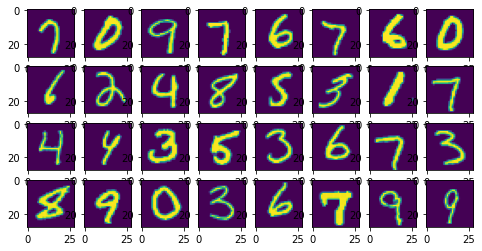

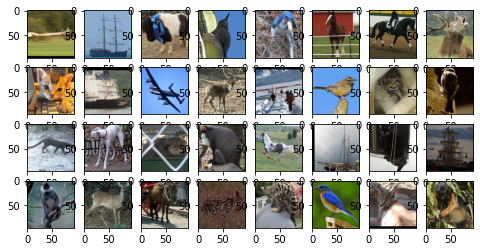

In [57]:
def show(imgs):
    # your code goes here:
  plt.figure(figsize=(8, 4))
  for i, item in enumerate(imgs):
      if i >= 32:
#        print('indexes error')
        break
      plt.subplot(4, 8, i+1)
#      img = item.numpy().transpose((1, 2, 0))
      plt.imshow(item)
#      plt.imshow(item[0].squeeze().numpy())

  return None

def show_random_images(imgs_nparray, N):
  xs = []
  for i in range(N):
    sample_idx = torch.randint(len(imgs_nparray), size=(1,)).item()
    img = imgs_nparray[sample_idx]
    xs.append(img)
  show(xs)

print('Random MNIST images:')
show_random_images(mnist_train_split.data, 32)
print('Random STL10 images:')
show_random_images(stl10_train_split, 32)



## Extrapolate in the image domain:

Here, randomly take 2 images from the training dataset, combine them together and plot the result. For example, consider $X_1$ and $X_2$ to be 2 images randomly taken from the training data. Plot $\alpha\cdot X_1 + (1-\alpha)\cdot X_2$. 

Explain the results, is extrapolation in the image domain reasonable?

Note: Recall that the images should be in the $[0,1]$ interval.

Extrapolate MNIST images o in the image domain:
img.shape: torch.Size([28, 28])
Extrapolate STL10 images in the image domain:
img.shape: (96, 96, 3)


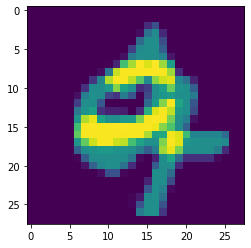

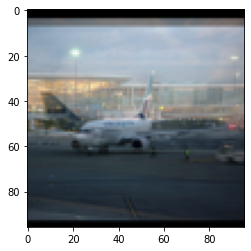

In [58]:
def extrapolte_images(imgs_nparray):
  sample_idx = torch.randint(len(imgs_nparray), size=(1,)).item()
  img1 = imgs_nparray[sample_idx]
  sample_idx = torch.randint(len(imgs_nparray), size=(1,)).item()
  img2 = imgs_nparray[sample_idx]
  alpha = 0.5

  img = alpha*img1 + (1-alpha)*img2
#  img = img3.numpy().transpose((1, 2, 0))
  plt.figure(clear=True)
  plt.imshow(img)
  print(f'img.shape: {img.shape}')

print('Extrapolate MNIST images o in the image domain:')
extrapolte_images(mnist_train_split.data)
print('Extrapolate STL10 images in the image domain:')
extrapolte_images(stl10_train_split)



# Section 3 CNN

## CNN Implementation

As seen in class, a suitable way to extract features from dataset of images is by convolutional neural network (CNN). Hence, here you will build a convolutional VAE.
\
The basic idea is to start from full resolution images, and by convolutional kernels extract the important features of the dataset. Remember that the output of the VAE should be in the same dimensions $(H_1,W_1,C_1)$ as the input images. 

**The encoder** should be comprised of convolutional layers (nn.Conv2d). Recall that the dimension of the input images is changing according to:

$Z = \bigg(H_2(=\frac{H_1-F+2P}{S}+1),W_2(=\frac{W_1-F+2P}{S}+1),C_2\bigg)$

where $S$ is the stride, $F$ is the kernel size, $P$ is the zero padding and $C_2$ is the selected output channels. $Z$ is the output image.




### CNN Architecture

Here, you will implement the architecture of the encoder. 

The encoder should consist of 4 Blocks as follows:

BLOCK 1: 
- Convolutional layer (nn.Conv2D(in_channels, num_hidden, kernel_size=(3,3), stride=(2,2)))
- Batch Normalization(num_hidden)
- Activation Function: nn.ReLU()

BLOCK 2: 
- Convolutional layer (nn.Conv2D(num_hidden, num_hidden * 2, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 2)
- Activation Function: nn.ReLU()

BLOCK 3: 
- Convolutional layer (nn.Conv2D(num_hidden * 2, num_hidden * 4, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 4)
- Activation Function: nn.ReLU()

BLOCK 4: 
- Convolutional layer (nn.Conv2D(num_hidden * 4, num_hidden * 8, kernel_size=(3,3), stride=(2,2))
- Batch Normalization(num_hidden * 8)
- Activation Function: nn.ReLU()

In addidion to the 4 Blocks, you should add the following linear layers:

Linear $\mu$: 
- nn.Linear( ___ ,latent). 

Linear $\log(\sigma)$: 
- nn.Linear( ___ ,latent).

**NOTES:** 

- The input of the linear layer should be according to the size of the images you picked in the transformation part. (If you did resize the images)

- Consider using Padding in the convolutional layers to correct mismatches in sizes.

- In the forward function, you will have to reshape the output from the 4'th block to $(Batch\cdot H_4\cdot W_4\cdot C_4 , latent)$, where $(Batch$ is the batch size, $H_4$ is the height of the output image from the 4'th block, $W_4$ is the width of the output image from the 4'th block and $C_4$ is num_hidden*8 (number of channels of the output image from the 4'th block).



In [59]:
class CNN(nn.Module):
    def __init__(self, in_channels, num_hiddens, numb_classes, input_shape=(1, 28, 28)):
        super(CNN, self).__init__()
        print(f'CNN: in_channels: {in_channels}, num_hiddens: {num_hiddens}, numb_classes: {numb_classes}, input_shape: {input_shape}')
        self.kernel_size = 3
        self.stride = 2
        self.in_channels = in_channels
        padding_num = int((self.kernel_size-1)/2)
        self.padding = (padding_num, padding_num)
        self.C, self.H, self.W = input_shape

        self.num_hiddens = num_hiddens
        self.numb_classes = numb_classes
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels, num_hiddens, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden)
            nn.BatchNorm2d(num_hiddens),
            nn.ReLU()
            )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(num_hiddens, num_hiddens * 2, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden*2)
            nn.BatchNorm2d(num_hiddens*2),
            nn.ReLU()
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(num_hiddens * 2, num_hiddens * 4, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden*4)
            nn.BatchNorm2d(num_hiddens*4),
            nn.ReLU()
        )
        
        self.block4 = nn.Sequential(
            nn.Conv2d(num_hiddens * 4, num_hiddens * 8, kernel_size=(self.kernel_size,self.kernel_size), stride=(self.stride,self.stride), padding=self.padding),
            # Batch Normalization(num_hidden*8)
            nn.BatchNorm2d(num_hiddens*8),
            nn.ReLU()

        )
        self.flatten = torch.nn.Flatten()
        self.le_relu = torch.nn.LeakyReLU(0.1)
        self.relu = torch.nn.ReLU()
        self.logsoftmax = torch.nn.LogSoftmax(dim=1)
      # after 4 Conv2D with stride=(2,2), the image shape is (h/(2**4),w/(2**4)), with 8*num_hiddens channels
      # thus, Linear input shape: (8*num_hiddens)*((self.H*self.W)/(2**8))
        fc1_inp = int((8*self.num_hiddens)*((self.H*self.W)/(2**8)))

        self.fc1 = torch.nn.Linear(in_features=fc1_inp, out_features=100)
        self.fc2 = torch.nn.Linear(in_features=100, out_features=numb_classes)

        # n_linear_size = int(((image_h-3)/2 + 1)**2)
#        print(f'fc1_inp: {fc1_inp}')
#        self.fc_mu = nn.Linear(fc1_inp, latent)     # Insert the input size
#        self.fc_logvar = nn.Linear(fc1_inp, latent) # Insert the input size

    # Initialize Weights - TODO: lets try it
    def weight_init(self, mean, std):
        for m in self._modules:
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                m.weight.data.normal_(mean, std)
                m.bias.data.zero_()

    def forward(self, inputs):
        # YOUR CODE GOES HERE:
        if DEBUG_NN:
          print(f'encoder forward: inputs.shape: {inputs.shape}')
        x = self.le_relu(self.block1(inputs))
        if DEBUG_NN:
          print(f'block1(x): x.shape: {x.shape}')

        x = self.le_relu(self.block2(x))
        if DEBUG_NN:
          print(f'block2(x): x.shape: {x.shape}')

        x = self.le_relu(self.block3(x))
        if DEBUG_NN:
          print(f'block3(x): x.shape: {x.shape}')

        x = self.le_relu(self.block4(x))
        if DEBUG_NN:
          print(f'block4(x): x.shape: {x.shape}')

        #x.view(-1, image_h*image_w*3), self.num_hiddens, self.latent
        x = self.flatten(x)
        if DEBUG_NN:
          print(f'flatten(x): x.shape: {x.shape}')

        y = self.relu(self.fc1(x))
        y = self.fc2(y)
        out = self.logsoftmax(y)
#        print(f'fc1(x): z.shape: {z.shape}')
#        mu = self.fc_mu(x)
#        logvar = self.fc_logvar(x)
        if DEBUG_NN:
          print(f'log_softmax out.shape: {out.shape:}')
        return out

### Loss Function


In [60]:
def get_accuracy(dataset, model, data_loader, dataset_size, stl10_labels_split, batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """

    # TODO: pass relevant data split
    # interact the data split
#    if DEBUG:
#      print(f'get_accuracy run')

    with torch.no_grad():
        model.eval()
        correct = 0
        labels_idx = 0
        for batch_idx, batch in enumerate(data_loader):
            labels = []
            if dataset == 'Mnist':
              img, labels = batch
#              labels = labels.cpu().detach().numpy().tolist()
              labels = labels.cpu().detach().numpy()
            else:
              img = batch
              N, H, W, C = img.shape
              img = img.view(N,C,H,W)
              labels = stl10_labels_split[labels_idx:(labels_idx+batch_size)]
              labels_idx += batch_size
            img = img.to(dev)
#            oh_labels = torch.Tensor(np.array(np.eye(10)[labels])).to(dev)
            if dataset_size//batch_size == batch_idx: 
                break
#            if DEBUG:
#              print(f'get_accuracy: test img.shape: {img.shape}')
            # ===================forward=====================
            zs = model(img)
            pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
            pred = pred.cpu().detach().numpy()
#            print(f'pred: {pred}')
#            print(f'pred.shape: {pred.shape}')
#            print(f'labels.shape: {labels.shape}')
#            print(f'type(labels): {type(labels)}')
#            print(f'labels: {labels}')
#            tt = pred == labels
#            print(f'tt: {tt}')
#            print(f'oh_labels.shape: {oh_labels.shape}')
#            tt = pred == oh_labels
#            print(f'tt with oh_labels: {tt}')
            correct += (pred == labels).sum()
#            correct += (pred == 1).sum()

    return correct / dataset_size

## CNN Training



### Training function

In [61]:
def plot_learning_curve(iters, losses, epocs_vec, train_accs, test_accs):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Accuracy per Epoch")
    plt.plot(epocs_vec, train_accs, label="Train")
    plt.plot(epocs_vec, test_accs, label="Test")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
'''
    fig, axs = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle("Learning Curve: Accuracy per Epoch")

    axs[0].plot(epocs_vec, train_accs, label="Train")
    axs[0].plot(epocs_vec, test_accs, label="Test")
    axs[0].set_title('Train vs Test Accuracy')
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()
'''
    

'\n    fig, axs = plt.subplots(1, 2, figsize=(15,5))\n    fig.suptitle("Learning Curve: Accuracy per Epoch")\n\n    axs[0].plot(epocs_vec, train_accs, label="Train")\n    axs[0].plot(epocs_vec, test_accs, label="Test")\n    axs[0].set_title(\'Train vs Test Accuracy\')\n    axs[0].set_xlabel("Epochs")\n    axs[0].set_ylabel("Accuracy")\n    axs[0].legend()\n'

In [62]:
def train(dataset, model, numb_classes, train_loader, test_loader, num_epochs=10, learning_rate=1e-3, batch_size=10, train_dataset_size=64, test_dataset_size=64, weight_decay=0):
    '''  
    This is a starter code for the training process. You can modify it for your 
    own conveinient.
    num_epochs - number of training epochs
    batch_size - size of the batches
    dataset_size - How many training samples to use. 
    model - The model you are training.   

    Note: decide what are the outputs of the function. 
    '''
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#    train_iters, test_iters, train_losses, test_losses, epocs_vec = [], [], [], [], []

    iters, losses = [], []
    epocs_vec, train_losses, test_losses, train_accs, test_accs  = [], [] ,[], [] ,[]

    n = 0 # total number of iterations
    nt = 0 # total number of test iterations

    for epoch in range(num_epochs):
      model.train()
      train_loss = 0
      labels_idx = 0
      for batch_idx, batch in enumerate(train_loader):
        labels = []
        if dataset == 'Mnist':
          imgs, labels = batch
        else:
          imgs = batch
          # reshape - for STL10
          N, H, W, C = imgs.shape
          imgs = imgs.view(N,C,H,W)
          labels = stl10_labels_train_split[labels_idx:(labels_idx+batch_size)]
          labels_idx += batch_size

        if DEBUG:
          print(f'len(labels): {len(labels)}, labels_idx: {labels_idx}')
          print(f'train imgs.shape: {imgs.shape}')
        imgs = imgs.to(dev)

#        print(f'train imgs.shape: {imgs.shape}')
        # Since the dataset is large, train on 'train_dataset_size' samples.
        if train_dataset_size//batch_size == batch_idx: 
            break

        # labels (one-hot representation)
#        print(f'labels: {labels}')
        oh_labels = torch.Tensor(np.array(np.eye(numb_classes)[labels])).to(dev)

        # ===================forward=====================
#        x_recon, mu, logvar = model(imgs)
#        loss = vae_loss(x_recon, imgs, mu, logvar)
        y_hat = model(imgs)     # compute prediction logit
#        print(f'y_hat: {y_hat}')
#        print(f'y_hat.shape: {y_hat.shape}')
#        labels1 = torch.from_numpy(labels)
#        labels2 = torch.from_numpy(labels.T)
        if DEBUG:
          print(f'\n train orig labels.shape: {labels.shape}')
          print(f'one-hot oh_labels.shape: {oh_labels.shape}')
          print(f'train y_hat.shape: {y_hat.shape}\n')
        loss = criterion(y_hat, oh_labels)   # compute the total loss
#        if DEBUG:
#          print(f'\n train loss: {loss}')
#          print(f'train orig labels: {labels}')
#          print(f'one-hot oh_labels: {oh_labels}')
#          print(f'train y_hat: {y_hat}\n')
#        train_loss += loss.item()
        # ===================backward====================
        optimizer.zero_grad()   # a clean up step for PyTorch
        loss.backward()         # compute updates for each parameter
        optimizer.step()        # make the updates for each parameter

        iters.append(n)
        losses.append(float(loss)/batch_size)  # compute *average* loss

        # increment the iteration number
        n += 1

      # Testing - once per epoch
      train_acc = get_accuracy(dataset, model, train_loader, train_dataset_size, stl10_labels_train_split, batch_size=batch_size)
      train_accs.append(train_acc)

      test_acc = get_accuracy(dataset, model, test_loader, test_dataset_size, stl10_labels_test_split, batch_size=batch_size)
      test_accs.append(test_acc)

        # ===================log========================
      train_loss = float(loss.cpu().detach().numpy())
      epocs_vec.append(epoch)
#      test_loss = float(test_loss)/test_dataset_size
      train_loss = float(train_loss)/train_dataset_size
#      test_losses.append(test_loss)  # compute *average* loss
      train_losses.append(train_loss)  # compute *average* loss
#      print(f"Epoch {epoch}, Train Iter {n}, train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}")
      print(f"Epoch {epoch}, Train Iter {n}, train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, test_acc: {test_acc:.4f}")

    # saved statistics and the last batch
#    return train_iters, test_iters, train_losses, test_losses, epocs_vec
    return iters, losses, epocs_vec, np.array(train_accs), np.array(test_accs)


# Train


## Train Model Function

In [63]:
def train_model(train_dataset, test_dataset, enc_in_chnl=3, numb_classes=10, batch_size=10, num_epochs=5, image_shape=(3, 96, 96), dataset='STL10'):
  learning_rate = 2e-3

  #CNN Class inputs: 
  enc_num_hidden = 32
  if dataset == 'STL10':
    train_dataset_size = train_dataset.shape[0]
    test_dataset_size = test_dataset.shape[0]
  else: # 'Mnist'
    train_dataset_size = train_dataset.data.shape[0]
    test_dataset_size = test_dataset.data.shape[0]

  #mnist_test_split, mnist_train_split = None, None
  #stl10_test_split, stl10_train_split = None, None

  # Train STL10

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

  model_1 = CNN(enc_in_chnl, enc_num_hidden, numb_classes, input_shape=image_shape)
  model_1.to(dev)
  model_1.weight_init(mean=0, std=0.02)
  iters, losses, epocs_vec, train_accs, test_accs = train(dataset, model_1, numb_classes, train_loader, test_loader, num_epochs, learning_rate, batch_size, train_dataset_size, test_dataset_size)
  plot_learning_curve(iters, losses, epocs_vec, train_accs, test_accs)

  return model_1


 ## Train STL10 CNN

### STL10 Toy CNN Training


CNN: in_channels: 3, num_hiddens: 32, numb_classes: 10, input_shape: (3, 96, 96)
Epoch 0, Train Iter 500, train_loss: 0.0005, train_acc: 0.9980, test_acc: 1.0001
Epoch 1, Train Iter 1000, train_loss: 0.0005, train_acc: 1.0000, test_acc: 1.0000
Epoch 2, Train Iter 1500, train_loss: 0.0005, train_acc: 1.0000, test_acc: 1.0000
Epoch 3, Train Iter 2000, train_loss: 0.0005, train_acc: 1.0000, test_acc: 1.0000
Epoch 4, Train Iter 2500, train_loss: 0.0005, train_acc: 1.0000, test_acc: 1.0000


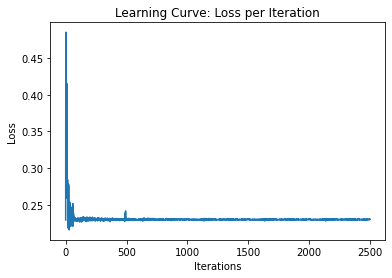

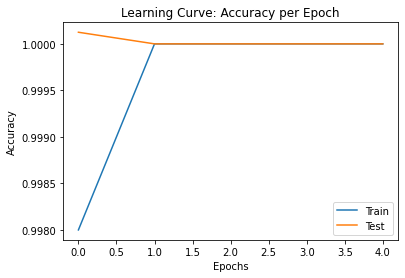

In [64]:
DEBUG = False
DEBUG_NN = False

model_1 = train_model(stl10_train_split, stl10_test_split, enc_in_chnl=3, numb_classes=10, batch_size=10, num_epochs=5, image_shape=(3, 96, 96), dataset='STL10')
#model_1 = train_model(stl10_train_split, stl10_test_split, 3, 10, 10, 5, (3, 96, 96), 'STL10')


### STL10 CNN Training


CNN: in_channels: 3, num_hiddens: 32, numb_classes: 10, input_shape: (3, 96, 96)
Epoch 0, Train Iter 50, train_loss: 0.0005, train_acc: 10.0000, test_acc: 10.0000
Epoch 1, Train Iter 100, train_loss: 0.0005, train_acc: 10.0000, test_acc: 10.0000
Epoch 2, Train Iter 150, train_loss: 0.0005, train_acc: 10.0000, test_acc: 10.0000
Epoch 3, Train Iter 200, train_loss: 0.0005, train_acc: 10.0000, test_acc: 10.0000
Epoch 4, Train Iter 250, train_loss: 0.0005, train_acc: 10.0000, test_acc: 10.0000
Epoch 5, Train Iter 300, train_loss: 0.0005, train_acc: 10.0000, test_acc: 10.0000
Epoch 6, Train Iter 350, train_loss: 0.0005, train_acc: 10.0000, test_acc: 10.0000
Epoch 7, Train Iter 400, train_loss: 0.0005, train_acc: 10.0000, test_acc: 10.0000
Epoch 8, Train Iter 450, train_loss: 0.0005, train_acc: 10.0000, test_acc: 10.0000
Epoch 9, Train Iter 500, train_loss: 0.0005, train_acc: 10.0000, test_acc: 10.0000
Epoch 10, Train Iter 550, train_loss: 0.0005, train_acc: 10.0000, test_acc: 10.0000
Epoch 

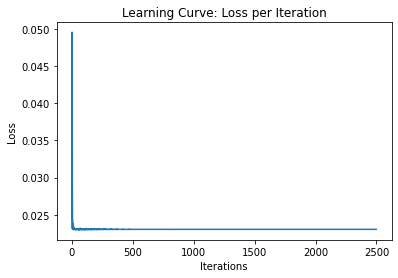

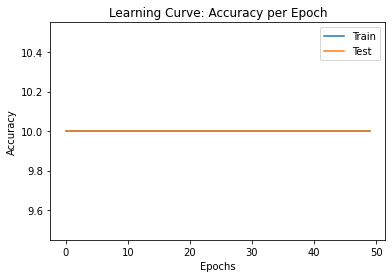

In [65]:
model_1_stl10 = train_model(stl10_train_split, stl10_test_split, enc_in_chnl=3, numb_classes=10, batch_size=100, num_epochs=50, image_shape=(3, 96, 96), dataset='STL10')


## Train MNIST CNN

### MNIST Toy CNN Training


CNN: in_channels: 1, num_hiddens: 32, numb_classes: 10, input_shape: (1, 32, 32)
Epoch 0, Train Iter 6000, train_loss: 0.0000, train_acc: 1.8803, test_acc: 1.8893
Epoch 1, Train Iter 12000, train_loss: 0.0000, train_acc: 1.8932, test_acc: 1.8931
Epoch 2, Train Iter 18000, train_loss: 0.0000, train_acc: 1.8914, test_acc: 1.8892
Epoch 3, Train Iter 24000, train_loss: 0.0000, train_acc: 1.8873, test_acc: 1.8749
Epoch 4, Train Iter 30000, train_loss: 0.0000, train_acc: 1.8994, test_acc: 1.8637


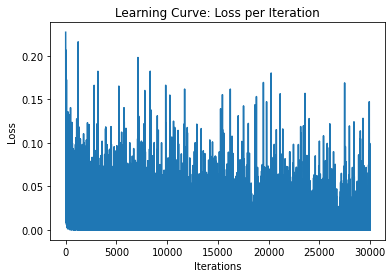

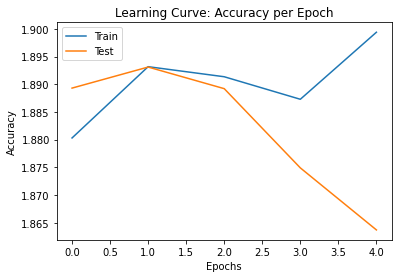

In [66]:
DEBUG = False
DEBUG_NN = False

model_2 = train_model(mnist_train_split, mnist_test_split, enc_in_chnl=1, numb_classes=10, batch_size=10, num_epochs=5, image_shape=(1, 32, 32), dataset='Mnist')


### MNIST CNN Training

CNN: in_channels: 1, num_hiddens: 32, numb_classes: 10, input_shape: (1, 32, 32)
Epoch 0, Train Iter 120, train_loss: 0.0000, train_acc: 50.9628, test_acc: 50.9623
Epoch 1, Train Iter 240, train_loss: 0.0000, train_acc: 50.9213, test_acc: 51.0976
Epoch 2, Train Iter 360, train_loss: 0.0000, train_acc: 50.9919, test_acc: 50.9620
Epoch 3, Train Iter 480, train_loss: 0.0000, train_acc: 51.0204, test_acc: 50.8221
Epoch 4, Train Iter 600, train_loss: 0.0000, train_acc: 51.0081, test_acc: 51.0113
Epoch 5, Train Iter 720, train_loss: 0.0000, train_acc: 50.9673, test_acc: 50.9503
Epoch 6, Train Iter 840, train_loss: 0.0000, train_acc: 51.0315, test_acc: 50.9515
Epoch 7, Train Iter 960, train_loss: 0.0000, train_acc: 51.0147, test_acc: 50.9765
Epoch 8, Train Iter 1080, train_loss: 0.0000, train_acc: 51.0532, test_acc: 50.9848
Epoch 9, Train Iter 1200, train_loss: 0.0000, train_acc: 51.0700, test_acc: 51.1613
Epoch 10, Train Iter 1320, train_loss: 0.0000, train_acc: 51.0382, test_acc: 50.8927
Ep

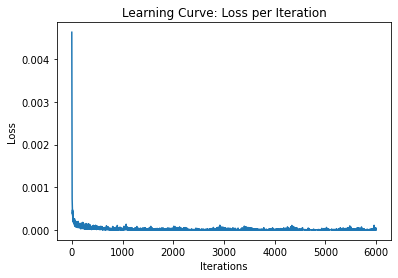

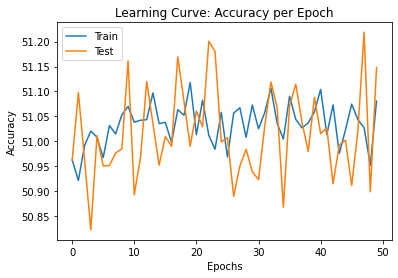

In [67]:
DEBUG = False
DEBUG_NN = False

model_2_mnist = train_model(mnist_train_split, mnist_test_split, enc_in_chnl=1, numb_classes=10, batch_size=500, num_epochs=50, image_shape=(1, 32, 32), dataset='Mnist')


## Save Trained Models

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Save models in GDrive for future use
model_path_stl10_beta = model_path_stl10.split('.')[0] + '_sup_stl10' + '.pk'
model_path_mnist_beta = model_path_mnist.split('.')[0] + '_sup_mnist' + '.pk'

if (model_path_stl10 is not None):
    torch.save(model_1_stl10.state_dict(), model_path_stl10_beta)
if (model_path_mnist is not None):
    torch.save(model_2_mnist.state_dict(), model_path_mnist_beta)


# Automatic PDF Generation and store in GDrive

In [ ]:
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc > /dev/null 2>&1
!pip install pypandoc > /dev/null 2>&1

from google.colab import drive
drive.mount('/content/drive')
!cp 'drive/My Drive/Colab Notebooks/Assignment4_work.ipynb' ./

!jupyter nbconvert --to PDF "Assignment4_work.ipynb" > /dev/null 2>&1
!echo "pdf file generated"
#!ls -la
!cp './Assignment4_work.pdf' 'drive/My Drive/Colab Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
pdf file generated
